# Energy Use in Liverpool City Region
This notebook uses some Python tools to display gas and electricity use in liverpool city region.


In [3]:
import pandas as pd ##Pandas to manipulate data
import geopandas as gpd ##GeoPandas to manipulate GeoSpacial data
import folium ##Folium to create interactive maps
import numpy as np ##For a number of useful mathematical functions 
import requests as rq
from shapely.geometry import box, polygon ##Use this to create the grid covering LCR

We are using the follow sources of data
1. Lower and Middle Super Output Areas electricity consumption https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-electricity-consumption
    * LSOA Domestic Electricity 2010 to 2022
    * MSOA Non-Domestic Electricity 2010 to 2022
2. Lower and Middle Super Output Areas gas consumption https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-gas-consumption
    * LSOA Domestic Gas 2010 to 2022
    * MSOA Non-Domestic Gas 2010 to 2022

Geospatial data giving the boundaries of all LSOAs and MSOAs are provided by the ONS. We also need to look up which output areas are in Liverpool City Region. 

In [2]:
lsoa_lep_lookup = pd.read_csv('data/Lower_layer_Super_Output_Area_(2021)_to_Local_Enterprise_Partnership_(December_2022)_Lookup_in_England_(V2).csv') #Use this dataset to find out which LSOAs are in LCR, from https://geoportal.statistics.gov.uk/
lsoa_boundaries = gpd.read_file('data/Lower_layer_Super_Output_Areas_2021_EW_BGC_V3_-3320468682147951291.geojson') #Boundaries of all LSOAs in england from https://geoportal.statistics.gov.uk/
lsoa_elc_data = pd.read_excel('data/LSOA_domestic_elec_2010-22.xlsx',sheet_name="2022",skiprows=4) #Domestic electricity use across England https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-electricity-consumption
lsoa_gas_data = pd.read_excel("data/LSOA_domestic_gas_2010-2022.xlsx",sheet_name="2022",skiprows=4) #Domestic gas use across England https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-gas-consumption

In [3]:
lsoa_lcr_lookup = lsoa_lep_lookup[lsoa_lep_lookup['LEP22CD1']=='E37000022'] #Returns only those LSOAs which are in Liverpool City Region

In [4]:
lcr_lsoa_boundaries=lsoa_boundaries.merge(lsoa_lcr_lookup,how='inner',on='LSOA21CD')[['LSOA21CD','LSOA21NM_x','BNG_E','BNG_N','LONG','LAT','GlobalID','geometry']] #Returns the boundaries of LSOAs in LCR
lcr_lsoa_boundaries.rename(columns={"LSOA21NM_x":"LSOA21NM"},inplace=True) #Renames columns to more sensible name

In [5]:
lsoa_elc_data.rename(columns={
    "Number\nof meters":"Number of Electric Meters",
    "Total \nconsumption\n(kWh)":"Total Electricity Use",
    "Mean \nconsumption\n(kWh per meter)":"Mean Electricity Use",
    "Median \nconsumption\n(kWh per meter)":"Median Electricity Use"},
                     inplace=True) #Renames columns
lsoa_gas_data.rename(columns={
    "Number\nof meters\n":"Number of Gas Meters",
    "Total \nconsumption\n(kWh)":"Total Gas Use",
    "Mean \nconsumption\n(kWh per meter)":"Mean Gas Use",
    "Median \nconsumption\n(kWh per meter)":"Median Gas Use",
    "Number of\nnon-consuming meters":"Unused Gas Meters"},
                     inplace=True) #Renames columns
lcr_lsoa_elc_data = pd.merge(lsoa_elc_data,lcr_lsoa_boundaries[['LSOA21CD']],left_on="LSOA code",right_on="LSOA21CD",how='inner') #Returns electricity per LSOA for LCR only
lcr_lsoa_elc_data.drop("LSOA21CD",axis="columns",inplace=True) #Drops duplicate columns 
lcr_lsoa_gas_data = pd.merge(lsoa_gas_data,lcr_lsoa_boundaries[['LSOA21CD']],left_on="LSOA code",right_on="LSOA21CD",how='inner')
lcr_lsoa_gas_data.drop("LSOA21CD",axis="columns",inplace=True) #Drops duplicate columns
lcr_lsoa_energy_data=pd.merge(lcr_lsoa_elc_data,lcr_lsoa_gas_data[["LSOA code","Number of Gas Meters","Total Gas Use","Mean Gas Use","Unused Gas Meters"]],on="LSOA code",how="inner") #Creates one file with both electric and gas data

In [6]:
##Define a function which takes a GeoDataFrame and returns an nxm grid of sqaures covering the entire area. 
def grid(geo_data,n):
    bounds=geo_data.total_bounds
    cell_size=(bounds[2]-bounds[0])/n
    grid_cells=[]
    for x0 in np.arange(bounds[0],bounds[2],cell_size):
        for y0 in np.arange(bounds[1],bounds[3],cell_size):
            grid_cells.append(box(x0,y0,x0+cell_size,y0+cell_size))
    return gpd.GeoDataFrame(grid_cells,columns=['geometry'],crs=geo_data.crs)

We might be interested in mapping the energy use by LSOA onto different geographies. Below is an exmaple of how to do this. First we generate a grid covering LCR and then assign energy usage to each grid tile based on the energy use in intersecting LSOAs. Each LSOA which intersects contributes energy usage in proportion to the area of the LSOA which intersects the grid tile. 

In [7]:
lcr_grid=grid(lcr_lsoa_boundaries,50) #Create a grid covering LCR 
#Calculate the total energy use in each grid. This is done by finding what proportion of each LSOA is in each grid sqaure and then assigning that proportion of energy use in that LSOA to that grid sqaure. 
drop_rows = [] #Use this to keep track of which cells are empty, so we can remove them. 
for i in lcr_grid.index: #Iterate over each grid tile
    intersect = gpd.overlay(lcr_grid.iloc[[i]],lcr_lsoa_boundaries) #This creates a GeoDataFrame with a polygon for each LSOA which intersects the grid tile, clipped to the boundaries of the tile. 
    if intersect.empty: #Check if no intersecting LSOAs 
        drop_rows.append(i) #If so remember this so we can remove it at the end. 
    else: #Otherwise go on to calculate the energy use. 
        elc_use=0 
        gas_use=0 
        for j in intersect.index: #Look at each LSOA which intersects the tile
            lsoa=intersect.loc[j]["LSOA21CD"] #Find the code of the LSOA
            intersect_area=intersect.loc[[j]]["geometry"].area #Find the area of the LSOA which intersects the tile
            lsoa_area=lcr_lsoa_boundaries[lcr_lsoa_boundaries["LSOA21CD"]==lsoa].area #Find the total area of the LSOA
            proportion=intersect_area.iloc[0]/lsoa_area.iloc[0] #The proportion of the LSOA within the tile
            lsoa_elc_use=lcr_lsoa_elc_data[lcr_lsoa_elc_data["LSOA code"]==lsoa]["Total Electricity Use"].iloc[0] #The total elctricity use in the LSOA
            lsoa_gas_use=lcr_lsoa_gas_data[lcr_lsoa_gas_data["LSOA code"]==lsoa]["Total Gas Use"].iloc[0] #Total gas use in the LSOA
            elc_use=elc_use + lsoa_elc_use*proportion #Add the relevant proportion of electricity to our overall total for the tile. 
            gas_use=gas_use + lsoa_gas_use*proportion #same for gas. 
        lcr_grid.at[i,"total electricity use"]=elc_use #Assgin the calculated electric use to the grid tile
        lcr_grid.at[i,"total gas use"]=gas_use #Assign the calculate dgas use to the grid tile
lcr_grid.drop(drop_rows,inplace=True) #Drop empty cells 
lcr_grid.reset_index(inplace=True) #Take the index and create a new column with the same values, i need this properly assign the right numbers to the right tiles in the map, proabably so way around this. 

In [8]:
#Creates a folium map with 4 layers: LSOA electric and gas use and Electric and Gas density maps based on the grid above. 
map = folium.Map(location=[53.41409787567685, -2.9965689152099486]) #Create the map, centred on liverpool. 

#Here we add a layer
folium.Choropleth(                                      #Creates a Choropleth data visualisation
    geo_data=lcr_lsoa_boundaries,                       #The underlying geographies we want to colour are the LSOA boundaries
    data=lcr_lsoa_elc_data,                             #The data we want to visualise  
    name="Total electricity Use by LSOA (kWh)",         #The name of the layer
    columns=["LSOA code", "Total Electricity Use"],     #The column we want to visualise is "total electricty use" and the "LSOA code" tells us which shape on the map to assign it to   
    key_on="feature.properties.LSOA21CD",               #The shapes on the map we want to assign the colors to. 
).add_to(map)

folium.Choropleth(
    geo_data=lcr_lsoa_boundaries,
    data=lcr_lsoa_gas_data,
    name="Total gas use by LSOA (kWh)",
    fill_color="OrRd",                                  #Show gas in red instead of blue. 
    columns=["LSOA code", "Total Gas Use"],
    key_on="feature.properties.LSOA21CD",
).add_to(map)
folium.Choropleth(
    geo_data=lcr_grid,
    data=lcr_grid,
    name="Electricity Density",                   #Show grid tiles which don't interesect with any LSOAs as grey. 
    columns=["index", "total electricity use"],
    key_on="feature.properties.index",
).add_to(map)
folium.Choropleth(
    geo_data=lcr_grid,
    data=lcr_grid,
    name="Gas Density",
    fill_color="OrRd",
    columns=["index", "total gas use"],
    key_on="feature.properties.index",
).add_to(map)
folium.LayerControl().add_to(map) #Adds layer control

In [9]:
map.save("EnergyUseMap.html")

<Axes: >

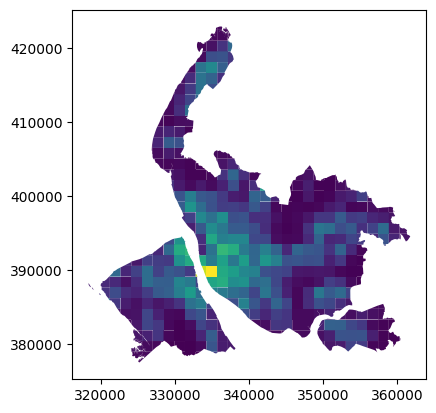

In [10]:
test_grid=grid(lcr_lsoa_boundaries,30) #Create a grid covering LCR 
#Calculate the total energy use in each grid. This is done by finding what proportion of each LSOA is in each grid sqaure and then assigning that proportion of energy use in that LSOA to that grid sqaure. 
drop_rows = [] #Use this to keep track of which cells are empty, so we can remove them. 
for i in test_grid.index: #Iterate over each grid tile
    intersect = gpd.overlay(test_grid.iloc[[i]],lcr_lsoa_boundaries)
    if intersect.empty: #Check if no intersecting LSOAs 
        drop_rows.append(i) #If so remember this so we can remove it at the end. 
    else: #Otherwise go on to calculate the energy use.
        land_area = test_grid.area[i]/intersect.dissolve().area[0]
        elc_use=0 
        gas_use=0 
        for j in intersect.index: #Look at each LSOA which intersects the tile
            lsoa=intersect.loc[j]["LSOA21CD"] #Find the code of the LSOA
            intersect_area=intersect.loc[[j]]["geometry"].area #Find the area of the LSOA which intersects the tile
            lsoa_area=lcr_lsoa_boundaries[lcr_lsoa_boundaries["LSOA21CD"]==lsoa].area #Find the total area of the LSOA
            proportion=intersect_area.iloc[0]/lsoa_area.iloc[0] #The proportion of the LSOA within the tile
            lsoa_elc_use=lcr_lsoa_elc_data[lcr_lsoa_elc_data["LSOA code"]==lsoa]["Total Electricity Use"].iloc[0] #The total elctricity use in the LSOA
            lsoa_gas_use=lcr_lsoa_gas_data[lcr_lsoa_gas_data["LSOA code"]==lsoa]["Total Gas Use"].iloc[0] #Total gas use in the LSOA
            elc_use=elc_use + lsoa_elc_use*proportion #Add the relevant proportion of electricity to our overall total for the tile. 
            gas_use=gas_use + lsoa_gas_use*proportion #same for gas. 
        gas_use=gas_use*land_area
        elc_use=elc_use*land_area
        test_grid.at[i,"total electricity use"]=elc_use #Assgin the calculated electric use to the grid tile
        test_grid.at[i,"total gas use"]=gas_use #Assign the calculate dgas use to the grid tile
        test_grid.at[i,"geometry"]=intersect.dissolve().at[0,"geometry"]
test_grid.drop(drop_rows,inplace=True) #Drop empty cells 
test_grid.reset_index(inplace=True) #Take the index and create a new column with the same values, i need this properly assign the right numbers to the right tiles in the map, proabably so way around this.
test_grid.plot(column="total electricity use")

<Axes: >

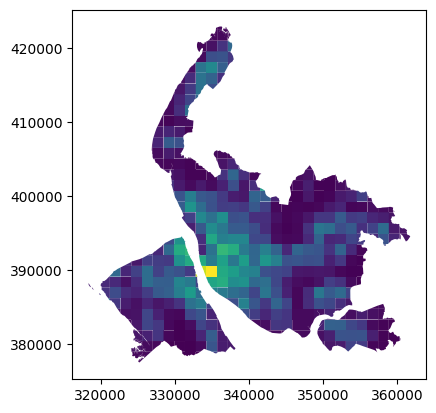

In [11]:
test_grid.plot(column="total electricity use")

In [12]:
test_grid.area[2]

44462.37064506803

In [20]:
all_veh_data = pd.read_csv('data/df_VEH0125.csv')[["LSOA11CD","LSOA11NM","BodyType","Keepership","LicenceStatus","2023 Q3"]] #Vehicle registration data by LSOA from https://www.gov.uk/government/statistical-data-sets/vehicle-licensing-statistics-data-files
piv_data = pd.read_csv('data/df_VEH0145.csv')[["LSOA11CD","LSOA11NM","Fuel","Keepership","2023 Q3"]] #Plug-in vehicle registration data

/tmp/ipykernel_1270/4277667305.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  all_veh_data = pd.read_csv('data/df_VEH0125.csv')[["LSOA11CD","LSOA11NM","BodyType","Keepership","LicenceStatus","2023 Q3"]] #Vehicle registration data by LSOA from https://www.gov.uk/government/statistical-data-sets/vehicle-licensing-statistics-data-files


In [21]:
lcr_lsoa11 = gpd.read_file('data/lcr_lsoa11_boundaries.json')

In [26]:
lcr_veh_all=pd.merge(all_veh_data,lcr_lsoa11['LSOA11CD'],how='inner',on="LSOA11CD")[lcr_veh_all['LicenceStatus']=='Licensed']
lcr_veh_piv=pd.merge(piv_data,lcr_lsoa11['LSOA11CD'],how='inner',on='LSOA11CD')

In [27]:
lcr_veh_all

LSOA11CD        LSOA11NM BodyType Keepership LicenceStatus 2023 Q3
0      E01006412   Knowsley 006A     Cars    Company      Licensed      62
1      E01006413   Knowsley 006B     Cars    Company      Licensed      71
2      E01006414   Knowsley 006C     Cars    Company      Licensed      55
3      E01006415   Knowsley 003A     Cars    Company      Licensed      47
4      E01006416   Knowsley 005A     Cars    Company      Licensed     137
...          ...             ...      ...        ...           ...     ...
11229  E01033764  Liverpool 022E    Total      Total      Licensed    1014
11230  E01033765  Liverpool 061D    Total      Total      Licensed     523
11231  E01033766  Liverpool 042G    Total      Total      Licensed     307
11232  E01033767  Liverpool 050J    Total      Total      Licensed     284
11233  E01033768  Liverpool 037F    Total      Total      Licensed     290

[11234 rows x 6 columns]

In [30]:
lcr_veh_all.pivot(index=['LSOA11CD','LSOA11NM'],columns=['BodyType','Keepership'],values='2023 Q3')

BodyType                    Cars Motorcycles Other body types   Total    Cars  \
Keepership               Company     Company          Company Company Private   
LSOA11CD  LSOA11NM                                                              
E01006412 Knowsley 006A       62         NaN              [c]      66     398   
E01006413 Knowsley 006B       71         NaN              [c]      74     346   
E01006414 Knowsley 006C       55         NaN              [c]      59     324   
E01006415 Knowsley 003A       47         NaN               17      64     734   
E01006416 Knowsley 005A      137           0              404     541     397   
...                          ...         ...              ...     ...     ...   
E01033764 Liverpool 022E     134           0               62     196     753   
E01033765 Liverpool 061D      80           0               22     102     399   
E01033766 Liverpool 042G      13         NaN              [c]      14     276   
E01033767 Liverpool 050J      22         NaN                0      22     240   
E01033768 Liverpool 037F      13         NaN              [c]      15     257   

BodyType                 Motorcycles Other body types   Total  Cars  \
Keepership                   Private          Private Private Total   
LSOA11CD  LSOA11NM                                                    
E01006412 Knowsley 006A            9               31     438   460   
E01006413 Knowsley 006B            8               35     389   417   
E01006414 Knowsley 006C            9               32     365   379   
E01006415 Knowsley 003A           18               62     814   781   
E01006416 Knowsley 005A          [c]               33     432   534   
...                              ...              ...     ...   ...   
E01033764 Liverpool 022E          11               54     818   887   
E01033765 Liverpool 061D         [c]               19     421   479   
E01033766 Liverpool 042G         [c]               15     293   289   
E01033767 Liverpool 050J           5               17     262   262   
E01033768 Liverpool 037F         [c]               14     275   270   

BodyType                 Motorcycles Other body types Total  
Keepership                     Total            Total Total  
LSOA11CD  LSOA11NM                                           
E01006412 Knowsley 006A            9               35   504  
E01006413 Knowsley 006B            8               38   463  
E01006414 Knowsley 006C            9               36   424  
E01006415 Knowsley 003A           18               79   878  
E01006416 Knowsley 005A          [c]              437   973  
...                              ...              ...   ...  
E01033764 Liverpool 022E          11              116  1014  
E01033765 Liverpool 061D         [c]               41   523  
E01033766 Liverpool 042G         [c]               16   307  
E01033767 Liverpool 050J           5               17   284  
E01033768 Liverpool 037F         [c]               16   290  

[989 rows x 12 columns]

In [16]:
lcr_veh_all[lcr_veh_all.duplicated(keep=False)][lcr_veh_all["LSOA11CD"]=="E01006430"]

/tmp/ipykernel_1270/3704809226.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lcr_veh_all[lcr_veh_all.duplicated(keep=False)][lcr_veh_all["LSOA11CD"]=="E01006430"]


LSOA11CD       LSOA11NM          BodyType Keepership 2023 Q3
992    E01006430  Knowsley 018C       Motorcycles    Company       0
1362   E01006430  Knowsley 018C  Other body types    Company     [c]
12098  E01006430  Knowsley 018C       Motorcycles    Company       0
12381  E01006430  Knowsley 018C  Other body types    Company     [c]

In [18]:
big_veh_data = pd.read_csv('data/df_VEH0125.csv')

/tmp/ipykernel_1270/3042236014.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60) have mixed types. Specify dtype option on import or set low_memory=False.
  big_veh_data = pd.read_csv('data/df_VEH0125.csv')


In [19]:
big_veh_data[big_veh_data["LSOA11CD"]=="E01006430"]

LSOA11CD       LSOA11NM          BodyType Keepership LicenceStatus  \
7159    E01006430  Knowsley 018C              Cars    Company      Licensed   
46988   E01006430  Knowsley 018C       Motorcycles    Company      Licensed   
71529   E01006430  Knowsley 018C  Other body types    Company      Licensed   
114117  E01006430  Knowsley 018C             Total    Company      Licensed   
156740  E01006430  Knowsley 018C              Cars    Private      Licensed   
199360  E01006430  Knowsley 018C       Motorcycles    Private      Licensed   
241977  E01006430  Knowsley 018C  Other body types    Private      Licensed   
284597  E01006430  Knowsley 018C             Total    Private      Licensed   
327217  E01006430  Knowsley 018C              Cars      Total      Licensed   
369837  E01006430  Knowsley 018C       Motorcycles      Total      Licensed   
412455  E01006430  Knowsley 018C  Other body types      Total      Licensed   
455075  E01006430  Knowsley 018C             Total      Total      Licensed   
497199  E01006430  Knowsley 018C              Cars    Company          SORN   
531532  E01006430  Knowsley 018C       Motorcycles    Company          SORN   
552385  E01006430  Knowsley 018C  Other body types    Company          SORN   
593338  E01006430  Knowsley 018C             Total    Company          SORN   
635064  E01006430  Knowsley 018C              Cars    Private          SORN   
677684  E01006430  Knowsley 018C       Motorcycles    Private          SORN   
720296  E01006430  Knowsley 018C  Other body types    Private          SORN   
762910  E01006430  Knowsley 018C             Total    Private          SORN   
805530  E01006430  Knowsley 018C              Cars      Total          SORN   
848150  E01006430  Knowsley 018C       Motorcycles      Total          SORN   
890765  E01006430  Knowsley 018C  Other body types      Total          SORN   
933382  E01006430  Knowsley 018C             Total      Total          SORN   

       2023 Q3 2023 Q2 2023 Q1 2022 Q4 2022 Q3  ... 2012 Q1 2011 Q4 2011 Q3  \
7159        50      51      45      43      39  ...      35      35      34   
46988        0       0       0       0       0  ...       0       0       0   
71529      [c]     [c]     [c]     [c]     [c]  ...     [c]     [c]     [c]   
114117      52      54      48      47      43  ...      38      37      36   
156740     477     467     465     472     474  ...     282     280     276   
199360     [c]     [c]     [c]     [c]       5  ...       7       7       6   
241977      27      25      24      26      26  ...      11      11      14   
284597     508     495     493     502     505  ...     300     298     296   
327217     527     518     510     515     513  ...     317     315     310   
369837     [c]     [c]     [c]     [c]       5  ...       7       7       6   
412455      29      28      27      30      30  ...      14      13      16   
455075     560     549     541     549     548  ...     338     335     332   
497199     [c]     [c]     [c]     [c]     [c]  ...       0       0       0   
531532       0       0       0       0       0  ...       0       0       0   
552385     [c]     [c]     [c]     [c]     [c]  ...     [c]     [c]     [c]   
593338     [c]     [c]     [c]     [c]     [c]  ...     [c]     [c]     [c]   
635064      38      35      30      32      35  ...      11      14      20   
677684      11      10      10      10       9  ...     [c]     [c]     [c]   
720296       8       8       8       8       7  ...     [c]     [c]     [c]   
762910      57      53      48      50      51  ...      16      18      26   
805530      40      37      32      34      37  ...      11      14      20   
848150      11      10      10      10       9  ...     [c]     [c]     [c]   
890765      10      10      10      10       9  ...     [c]     [c]       5   
933382      61      57      52      54      55  ...      17      19      27   

       2011 Q2 2011 Q1 2010 Q4 2010 Q3 2010 Q2 2010 Q1 20